In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import random
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from pycox.models import utils
from pycox.utils import idx_at_times, kaplan_meier
import pandas as pd
import copy
import pickle
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
from sksurv.nonparametric import kaplan_meier_estimator
from collections import defaultdict

In [4]:
import os, sys
sys.path.append(os.path.abspath('..')) 

from baselines.config import Config, BASELINE_MODEL_FAMILY, TIME_INJECTION_MODEL_FAMILY
from baselines.train_utils import init_trainer, get_target
from baselines.utils import seed_everything
from baselines.datasets import load_data as load_data_base
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.dataset import load_data as load_data_trs
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.train_utils import Trainer

## Configurations for models:
- baselines    : `Config` need to be setup
- transformers : `STConfig` need to be setup
- classical Cox-spirit models (CPH, RSF) : not required

In [5]:
def setup_config_for_baselines(model_name, time_range='full'):
    cfg = Config
    cfg.model_name = model_name
    cfg.time_range = time_range
    cfg.setup()
    return cfg

def setup_config_for_transformers(model_name, dataset):
    # define the setup parameters
    STConfig.data = dataset
    if model_name == 'SurvTrace':
        STConfig.custom_training = False
    if model_name == "TRANS-TFI":
        STConfig.custom_training = True
        
    seed = STConfig.seed # 1234 
    set_random_seed(seed)

## Survival Functions

### 1. Baseline models
- `DeepHitSingle` : DeepHit (https://ojs.aaai.org/index.php/AAAI/article/view/11842)
- `CoxPH` : a.k.a DeepSurv (https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1)
<!-- - `DRSA` : Deep Recurrent Survival Analysis (https://ojs.aaai.org/index.php/AAAI/article/view/4407) -->

In [6]:
def infer_surv_of_baselines(model_name, dataset, time_range, group='uncensored', experiment_root='../scripts'):
    cfg = setup_config_for_baselines(model_name, time_range)
    model_save_dir = Path(experiment_root, cfg.model_save_dir)
    weight_file = model_save_dir / f"{cfg.model_name}_{cfg.time_range}_L{cfg.seq_len}_{dataset}.pth"
    trainer = init_trainer(cfg)
    trainer.preprocess(dataset)
    
    model = trainer.load_model_weights(weight_file)
    x_test, y_test = trainer.test
    
    if hasattr(model, 'compute_baseline_hazards'):
        model.training_data = trainer.train
        
    if group == 'uncensored':
        v = 1
    elif group == 'censored':
        v = 0

    durations_test, events_test = y_test.T

    t_train, e_train = get_target(trainer.df_train_raw)
    et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                        dtype=[('e', bool), ('t', float)])
    et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                           dtype=[('e', bool), ('t', float)])

    if trainer.interpolate_discrete_times:
        surv_full = model.interpolate(100).predict_surv_df(x_test)
    else:
        if hasattr(model, 'compute_baseline_hazards'):
            _ = model.compute_baseline_hazards()
        surv_full = model.predict_surv_df(x_test)
    
    idxs = np.where(events_test==v)
    x_test = x_test[idxs]
    durations_test = durations_test[idxs]
    
    if trainer.interpolate_discrete_times:
        surv = model.interpolate(100).predict_surv_df(x_test)
    else:
        if hasattr(model, 'compute_baseline_hazards'):
            _ = model.compute_baseline_hazards()
        surv = model.predict_surv_df(x_test)
    
    return surv_full, surv, durations_test, et_train, et_test

### 2. Transformer-based models
- `SurvTrace` : https://arxiv.org/pdf/2110.00855.pdf
- `TRANS-TFI`: Transformers for Time Feature Injection in Survival Analysis (newly proposed)

In [7]:
def infer_surv_of_transformers(model_name, dataset, group='uncensored', experiment_root='../scripts'):
    setup_config_for_transformers(model_name, dataset)
    
    # load data
    df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data_trs(STConfig)
    
    # get model
    model = SurvTraceSingle(STConfig)
    
    # initialize a trainer
    trainer = Trainer(model, dataset)
    trainer.ckpt = Path(experiment_root, trainer.ckpt)
    trainer.load_model_weights()
    model = trainer.model
        
    if group == 'uncensored':
        v = 1
    elif group == 'censored':
        v = 0
        
    df_train_all = df.loc[df_train.index]
    get_target_fn = lambda df: (df['duration'].values, df['event'].values)
    durations_train, events_train = get_target_fn(df_train_all)
    et_train = np.array([(events_train[i], durations_train[i]) for i in range(len(events_train))],
                    dtype = [('e', bool), ('t', float)])
    durations_test, events_test = get_target_fn(df_y_test)
    et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                dtype = [('e', bool), ('t', float)])

    surv_full = model.interpolate(100).predict_surv_df(df_test)
            
    df_test = df_test.loc[events_test==v]
    durations_test = durations_test[events_test==v]
    
    surv = model.interpolate(100).predict_surv_df(df_test)
    
    return surv_full, surv, durations_test, et_train, et_test

### 3. Classical Cox-spirit models
- Use scikit-survival implementations for:
    - `CPH` : Cox Proportional Hazards model ([link](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxPHSurvivalAnalysis.html))
    - `RSF` : Random Survival Forest ([link](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.ensemble.RandomSurvivalForest.html))

In [8]:
def format_labels(y):
    durations, events = y.T
    return np.array([(events[i], durations[i]) for i in range(len(y))],
                    dtype=[('e', bool), ('t', float)])

def infer_surv_of_cox_spirit_models(model_name, dataset, group='uncensored', experiment_root='../scripts', random_state=1234):
    seed_everything(random_state)
    x_train, x_val, x_test, y_train, y_val, y_test, df_train_raw, df_val_raw, df_test_raw, df_full, cols_standardize, cols_categorical = load_data_base(dataset, random_state=random_state)

    et_train = format_labels(y_train)
    et_test = format_labels(y_test)
        
    # Load model instance
    model_save_dir = './model_dir'
    model_save_path = Path(experiment_root) / model_save_dir / f"{model_name}_{dataset}.pkl"
    with open(model_save_path, 'rb') as f:
        model = pickle.load(f)
        
    if group == 'uncensored':
        v = 1
    elif group == 'censored':
        v = 0
        
    # Evaluation (full)
    surv_func = model.predict_survival_function(x_test)
    surv = np.row_stack([fn(fn.x) for fn in surv_func])
    surv_df_full = pd.DataFrame(surv.T, index=surv_func[0].x)
    risk_scores = model.predict(x_test)
            
    events, durations = pd.DataFrame.from_records(et_test).T.values
    idxs = np.where(events==v)
    x_test = x_test[idxs]
    durations_test = durations[idxs]

    # Evaluation
    surv_func = model.predict_survival_function(x_test)
    surv = np.row_stack([fn(fn.x) for fn in surv_func])
    surv_df = pd.DataFrame(surv.T, index=surv_func[0].x)

    return surv_df_full, surv_df, risk_scores, durations_test, et_train, et_test

### Plotting helper

In [9]:
def sort_legend(reference_list, order='descend'):

    handles, labels = plt.gca().get_legend_handles_labels()

    # Sort the labels based on the reference_list values
    sort_idx = sorted(range(len(reference_list)), key=lambda i: reference_list[i], reverse=(order=='descend'))
    sorted_labels = [labels[i] for i in sort_idx]

    # Use the sorted labels to create the legend
    plt.legend([handles[i] for i in sort_idx], sorted_labels)
    plt.grid(True)

### Curv similarity measure
- Fréchet distance : a metric to compare two curves or paths

In [10]:
def euclidean_distance(point1, point2):
    """
    Compute the Euclidean distance between two points.

    Parameters:
        point1 (tuple): The first point.
        point2 (tuple): The second point.

    Returns:
        float: The Euclidean distance between the two points.
    """
    return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))

def compute_distance_matrix(curve1, curve2):
    """
    Compute the distance matrix between two curves.

    Parameters:
        curve1 (list): The first curve, represented as a list of points.
        curve2 (list): The second curve, represented as a list of points.

    Returns:
        np.ndarray: The distance matrix between the two curves.
    """
    distance_matrix = np.zeros((len(curve1), len(curve2)))
    for i in range(len(curve1)):
        for j in range(len(curve2)):
            distance_matrix[i][j] = euclidean_distance(curve1[i], curve2[j])
    return distance_matrix

def compute_frechet_distance(curve1, curve2):
    """
    Compute the Fréchet distance between two curves.

    Parameters:
        curve1 (list): The first curve, represented as a list of points.
        curve2 (list): The second curve, represented as a list of points.

    Returns:
        float: The Fréchet distance between the two curves.
    """
    distance_matrix = compute_distance_matrix(curve1, curve2)
    min_distance_matrix = np.zeros((len(curve1), len(curve2)))

    min_distance_matrix[0][0] = distance_matrix[0][0]

    for i in range(1, len(curve1)):
        min_distance_matrix[i][0] = max(min_distance_matrix[i-1][0], distance_matrix[i][0])

    for j in range(1, len(curve2)):
        min_distance_matrix[0][j] = max(min_distance_matrix[0][j-1], distance_matrix[0][j])

    for i in range(1, len(curve1)):
        for j in range(1, len(curve2)):
            min_distance_matrix[i][j] = max(min(min_distance_matrix[i-1][j], min_distance_matrix[i][j-1], min_distance_matrix[i-1][j-1]), distance_matrix[i][j])

    return min_distance_matrix[-1][-1]


## Variables for experiments

In [11]:
BASELINES = ['DeepHitSingle', 'CoxPH', 'DRSA']
TRANSFORMERS = ['SurvTrace', 'TRANS-TFI']
COX_SPIRIT_MODELS = ['CPH', 'RSF']

dataset = 'dialysis' # (metabric | gbsg | dialysis)
model_list = COX_SPIRIT_MODELS + BASELINES + TRANSFORMERS
time_range = 'full' # used for baseline models
group = 'censored' # uncensored = event happend, censored = event not happened
experiment_root='../scripts'

## Fine-grained survival functions
- personalized survival functions (or individual survival functions) are compared

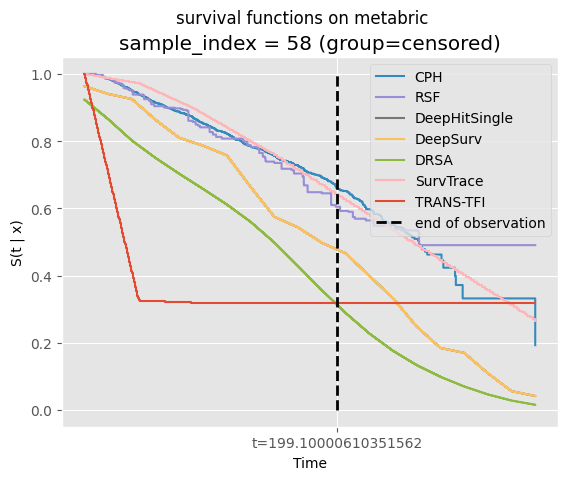

In [12]:
sample_index = random.randint(0, 100)

# dataset = metabric, group = uncensored (event happened)
# sample_index = 51
# sample_index = 86
# sample_index = 87
# sample_index = 89
# sample_index = 10
# sample_index = 44

# dataset = metabric, group = censored (event not happened)
# sample_index = 47
# sample_index = 76
# sample_index = 55
# sample_index = 57


# dataset = gbsg, group = uncensored (event happened)
# sample_index = 47
# sample_index = 69
# sample_index = 56
# sample_index = 58

# dataset = gbsg, group = censored (event not happened)
# sample_index = 73
# sample_index = 75
# sample_index = 79
# sample_index = 83
# sample_index = 84
# sample_index = 3

# for later usage
surv_results = {}
surv_full_results = {} 
cox_risk_scores = {}
et_train_test = {}

for i, model_name in enumerate(model_list):
    if model_name == 'CoxPH':
        model_name = 'DeepSurv'
    if model_name in BASELINES:
        surv_full, surv, durations_test, et_train, et_test = infer_surv_of_baselines(model_name, dataset, time_range, group=group, experiment_root=experiment_root)
    if model_name in TRANSFORMERS:
        surv_full, surv, durations_test, et_train, et_test = infer_surv_of_transformers(model_name, dataset, group=group, experiment_root=experiment_root)
    if model_name in COX_SPIRIT_MODELS:
        surv_full, surv, risk_scores, durations_test, et_train, et_test = infer_surv_of_cox_spirit_models(model_name, dataset, group, experiment_root=experiment_root)
        cox_risk_scores[model_name] = risk_scores

    plt.step(surv.index, surv.iloc[:, sample_index], where="post", color=f"C{i+1}", label=model_name)
    
    surv_results[model_name] = surv
    surv_full_results[model_name] = surv_full
    et_train_test[model_name] = (et_train, et_test)
    
plt.vlines(durations_test[sample_index], 0, 1, color='k', linestyles='--', linewidth=2, label='true event time' if group == 'uncensored' else 'end of observation')
plt.xticks([durations_test[sample_index]], labels=[f't={durations_test[sample_index]}'])
plt.suptitle(f"survival functions on {dataset}")
plt.title(f"sample_index = {sample_index} (group={group})")
plt.ylabel('S(t | x)')
plt.xlabel('Time')
# plt.ylim(0.8, 1.0)
# plt.xlim(0, 40)
plt.legend()
plt.grid(True)

In [13]:
if dataset == 'dialysis':
    va_times = [365 * 1, 365 * 3, 365 * 5, 365 * 7] # evaluate at 1yr, 3yr, 5yr, 7yr
    horizons = [ f"{i}yr" for i in [1,3,5,7] ]
else:
    va_times = STConfig['duration_index'][1:-1] # the discrete intervals are cut at 5%, 10%, 15%, ..., 95%
    horizons = STConfig['horizons']
    
print(f"va_times: {va_times}, \n horizons: {horizons}")

va_times: [ 42.68333435  85.8666687  145.33333588], 
 horizons: [0.25, 0.5, 0.75]


## Coarse-grained survival curves for each time horizon
- verifying our model's survival curve is clser to real survival curves
- iterate for each time horizon (1yr, 3yr, 5yr, 7yr)
- parenthesis meaning : Fréchet distance between real ones
- only for `dataset`=='dialysis'

In [14]:
if dataset == 'dialysis':
    
    surv_masks = {}

    for i, tau in enumerate(va_times):
        auc_list_for_legend = []
        for j, model_name in enumerate(model_list):
            if model_name == 'CoxPH':
                model_name = 'DeepSurv'

            surv = surv_full_results[model_name]
            et_train, et_test = et_train_test[model_name]
            surv_mask = (et_test['t'] < tau)
            if tau not in surv_masks:
                surv_masks[tau] = surv_mask
    
    et_train, et_test = et_train_test[model_name]
    surv_mask = (et_test['t'] < tau)
    for i, (yr, surv_mask) in enumerate(surv_masks.items()):
        time, real_survival_prob = kaplan_meier_estimator(et_test["e"][surv_mask], et_test["t"][surv_mask])
        plt.step(time, real_survival_prob, where="post", label='Real', linestyle='--', color='k', linewidth=2)
        
        dist_list_for_legend = [0.0]

        for j, model_name in enumerate(model_list):
            if model_name == 'CoxPH':
                model_name = 'DeepSurv'

            survival_num = []
            for k, tau in enumerate(time):
                surv = surv_full_results[model_name]
                surv = surv.loc[:, surv_mask]
                et_train, et_test = et_train_test[model_name]

                # select idx at times
                idx = idx_at_times(surv.index, [tau], 'post')
                y_scores = surv.iloc[idx].T.values
                y_pred = (y_scores > 0.5).astype(int) # 1 : survive, 0 : non-survive

                survival_prob = np.sum(y_pred) / len(y_pred)
                survival_num.append(survival_prob)
                
            curv1 = list(zip(time, survival_num))
            curv2 = list(zip(time, real_survival_prob))
            
            dist = compute_frechet_distance(curv1, curv2)
            plt.step(time, survival_num, where='post', label=f'{model_name} ({dist:.4f})', color=f'C{j}')
            dist_list_for_legend.append(dist)

        plt.title(f'Survival curves (time_horizon={horizons[i]})')
        sort_legend(reference_list=dist_list_for_legend, order='ascend')
        plt.show()

## Time-dependent analysis
- We predict the occurrence of an event in a period up to time `t` dynamically
- The model's predictability  is evaluate until varying time point `t`.

* Why do this?
    > At enrollment a subject is usually healthy, but may be diseased at some later time point. Consequently, sensitivity and specificity become time-dependent measures.

## ROC curves for each time horizon
- ROC curves for pre-defined time horizons (1,3,5,7yr) 
    - time horizons : observation duration
- only for `dataset`=='dialysis'

In [15]:
if dataset == 'dialysis':

    for i, tau in enumerate(va_times):
        auc_list_for_legend = []
        for j, model_name in enumerate(model_list):
            if model_name == 'CoxPH':
                model_name = 'DeepSurv'

            surv = surv_full_results[model_name]
            surv_mask = surv_masks[tau]

            # select idx at times
            idx = idx_at_times(surv.index, [tau], 'post')
            # select data based on tau
            surv = surv.loc[:, surv_mask]
            y_scores = surv.iloc[idx].T.values
            y_true = 1-et_test[surv.columns]['e']

            # calculate fpr, tpr, thresholds
            fpr, tpr, thresholds = roc_curve(y_true, y_scores)

            # calculate AUC
            roc_auc = auc(fpr, tpr)
            auc_list_for_legend.append(roc_auc)

            # plot ROC curve
            plt.plot(fpr, tpr, color=f'C{j}', label=f'{model_name} (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC (time horizon={horizons[i]})')
        sort_legend(reference_list=auc_list_for_legend)
        plt.show()